Connected to base (Python 3.11.11)

In [ ]:
import numpy as np
import pandas as pd
from nelson_langer_network import build_nelson_network
import time
from astrochem_clustering import AstrochemClusterModel

# Load parameters
datafile = np.load('data/tracer_parameter_data.npy')
datafile[:,0] *= 2
# ['nH', 'T', 'XH2', 'FUV', 'NH', 'zeta'] are the columns of datafile
data = datafile[:,[0, 1, 3]]
# data = datafile[:,[0, 1]]
data[:,[0,1]] = np.log10(data[:,[0,1]])
# data[:,2] /= 8.94e-14
params = pd.DataFrame(data=data, columns=['$\log(n_h)$', '$\log(T)$', '$G_0$'])

# Data for ode solves
# [H_2, H_3^+, e, He, He^+, C, CH_x, O, OH_x, CO, HCO^+, C^+, M^+, M]
#  0    1      2  3   4     5  6     7  8     9   10     11   12   13

# These are the initial conditions used by Nina in her testing code
x0 = np.array([
    0.5,
    9.059e-9,
    2e-4,
    0.1,
    7.866e-7,
    0.0,
    0.0,
    0.0004,
    0.0,
    0.0,
    0.0,
    0.0002,
    2.0e-7,
    2.0e-7
])
# From the overleaf doc
# x0 = np.array([
    # what should go here anyways?
# ])

secs_per_year = 3600*24*365
tf = 1000 * secs_per_year


def solve_nelson_network(params_row: np.ndarray, x0: np.ndarray, QoI: np.ndarray, time: float):
    n_h = 10**params_row[0]
    T = 10**params_row[1]
    G0 = params_row[2]
    network = build_nelson_network(n_h = n_h, T = T, G0 = G0)
    tvec, yvec = network.solve_reaction([0, time], x0)
    return yvec[QoI, -1]

In [ ]:
foo = np.load('data/medium_dataset_with_ode_solves.npy')
medium_dataset = pd.DataFrame(data=foo, columns=[
    '$\log(n_h)$',
    '$\log(T)$',
    '$G_0$',
    'e (t=100Y)',
    'H_2 (t=100Y)',
    'H_3+ (t=100Y)',
    'CO (t=100Y)',
    'C (t=100Y)',
    'e (t=1000Y)',
    'H_2 (t=1000Y)',
    'H_3+ (t=1000Y)',
    'CO (t=1000Y)',
    'C (t=1000Y)',
    'e (t=10000Y)',
    'H_2 (t=10000Y)',
    'H_3+ (t=10000Y)',
    'CO (t=10000Y)',
    'C (t=10000Y)',
])
np.random.seed(1234)
msk = np.random.rand(len(medium_dataset)) > 0.2
train = medium_dataset[msk]
test = medium_dataset[~msk]

In [ ]:
#    i.e. each training data point as a cluster centroid.
import faiss
centroids = train.to_numpy()[:,[0,1,2]]
QoI_values = train.to_numpy()[:,[8,9,10,11,12]]
faiss_index = faiss.IndexFlatL2(3)
faiss_index.add(centroids)

start_time = time.perf_counter()
D, I = faiss_index.search(test.to_numpy()[:,[0,1,2]], 1)
end_time = time.perf_counter()
total_time = end_time - start_time # in seconds
print(f'Time: {total_time:.2f} seconds')

datamat = np.zeros(shape=(len(test),24))
datamat[:,[0,1,2,3,4]] = test.to_numpy()[:,[8,9,10,11,12]] # exact (already solved)
I = np.matrix.flatten(I)
datamat[:,5] = I
datamat[:,[6,7,8,9,10]] = QoI_values[I] # predicted values
# percent errors
datamat[:,[11,12,13,14,15]] = np.abs(datamat[:,[6,7,8,9,10]] - datamat[:,[0,1,2,3,4]]) / np.abs(datamat[:,[0,1,2,3,4]])
# relative errors
datamat[:,[16,17,18,19,20]] = np.abs(datamat[:,[6,7,8,9,10]] - datamat[:,[0,1,2,3,4]])
# test data
datamat[:,[21,22,23]] = test.to_numpy()[:,[0,1,2]]

Time: 0.02 seconds


In [ ]:
ind = 11
print('Stats for e (1K years)')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
tol = 0.1
num_vals_outside_error = (datamat[:,ind] > tol).sum()
print(f'# of points outside {tol*100}% error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)\n')

ind = 12
print('Stats for H2 (1K years)')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > tol).sum()
print(f'# of points outside {tol*100}% error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)\n')

ind = 13
print('Stats for H3+ (1K years)')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > tol).sum()
print(f'# of points outside {tol*100}% error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)\n')

ind = 14
print('Stats for CO (1K years)')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > tol).sum()
print(f'# of points outside {tol*100}% error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)\n')

ind = 15
print('Stats for C (1K years)')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > tol).sum()
print(f'# of points outside {tol*100}% error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Stats for e (1K years)
Mean: 0.0029187861327391994
Median: 0.0013152798561098522
Max: 0.17004656246787836
STD: 0.005170035339027482
# of points outside 10.0% error: 3 (0.00025136154168412233% of data)

Stats for H2 (1K years)
Mean: 3.435846062042402e-08
Median: 1.5142828276977663e-08
Max: 7.133570055451947e-06
STD: 1.0712021708005033e-07
# of points outside 10.0% error: 0 (0.0% of data)

Stats for H3+ (1K years)
Mean: 0.009126468777215742
Median: 0.004393901117646465
Max: 0.8734698293696811
STD: 0.016521658468134498
# of points outside 10.0% error: 51 (0.00427314620863008% of data)

Stats for CO (1K years)
Mean: 0.01868020383711472
Median: 0.006662392335877929
Max: 50.647106562132
STD: 0.46411191892088105
# of points outside 10.0% error: 138 (0.011562630917469627% of data)

Stats for C (1K years)
Mean: 0.009850585614916082
Median: 0.0042051516758710855
Max: 6.9469635085359425
STD: 0.06529326014539692
# of points outside 10.0% error: 51 (0.00427314620863008% of data)


(array([6.398e+03, 1.930e+03, 1.339e+03, 7.920e+02, 4.850e+02, 3.210e+02,
        1.860e+02, 1.310e+02, 7.700e+01, 6.300e+01, 4.300e+01, 2.100e+01,
        1.900e+01, 2.000e+01, 1.300e+01, 7.000e+00, 1.300e+01, 8.000e+00,
        9.000e+00, 9.000e+00, 7.000e+00, 1.000e+00, 4.000e+00, 7.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        5.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165,

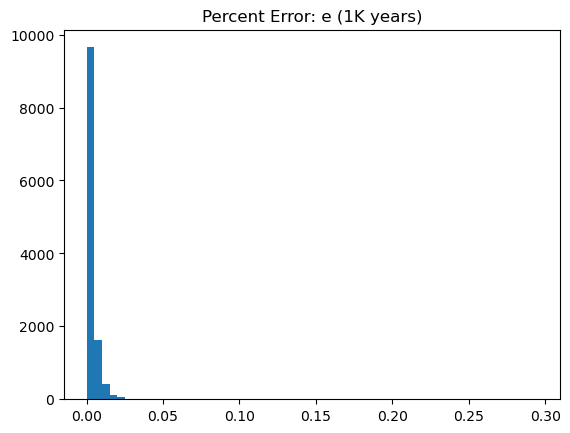

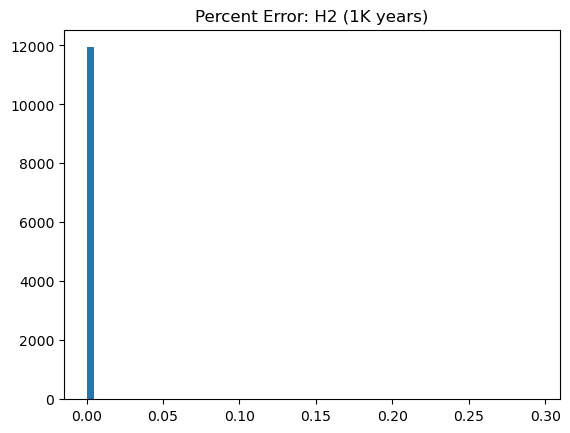

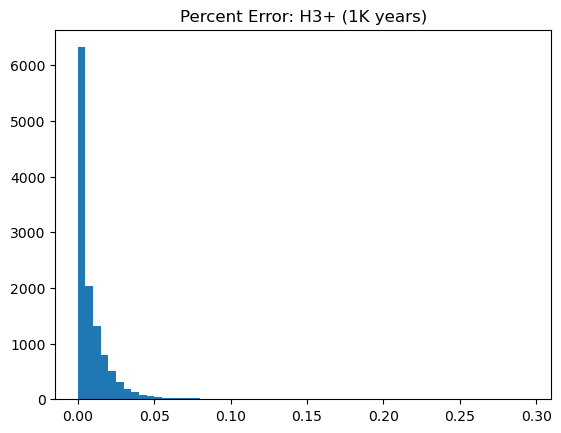

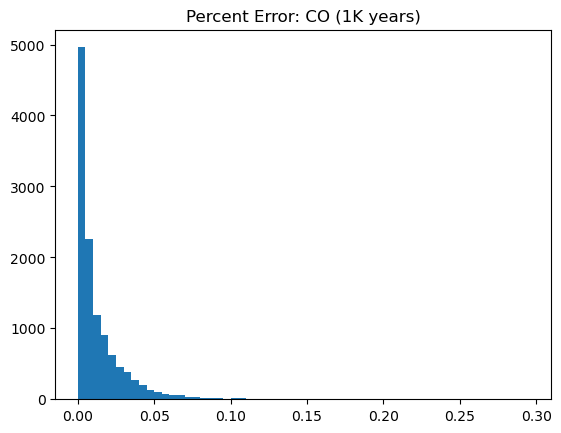

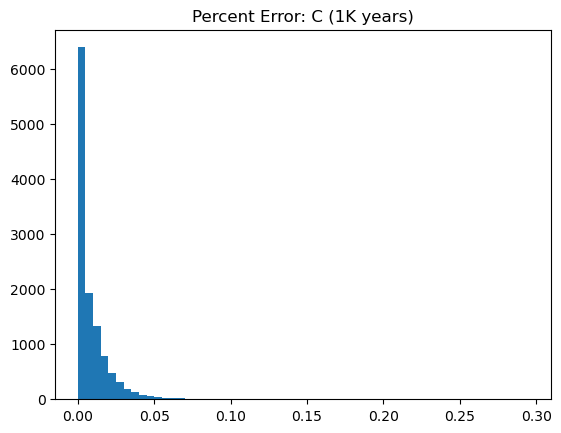

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Percent Error: e (1K years)')
plt.hist(datamat[:,11], bins=np.arange(0, 0.3, 0.005))
plt.figure()
plt.title('Percent Error: H2 (1K years)')
plt.hist(datamat[:,12], bins=np.arange(0, 0.3, 0.005))
plt.figure()
plt.title('Percent Error: H3+ (1K years)')
plt.hist(datamat[:,13], bins=np.arange(0, 0.3, 0.005))
plt.figure()
plt.title('Percent Error: CO (1K years)')
plt.hist(datamat[:,14], bins=np.arange(0, 0.3, 0.005))
plt.figure()
plt.title('Percent Error: C (1K years)')
plt.hist(datamat[:,15], bins=np.arange(0, 0.3, 0.005))

(array([1.000e+00, 1.800e+01, 1.790e+02, 1.527e+03, 5.070e+02, 3.200e+01,
        1.870e+02, 1.572e+03, 6.483e+03, 1.429e+03]),
 array([-15.72151298, -14.65859386, -13.59567474, -12.53275561,
        -11.46983649, -10.40691737,  -9.34399825,  -8.28107913,
         -7.21816001,  -6.15524089,  -5.09232176]),
 <BarContainer object of 10 artists>)

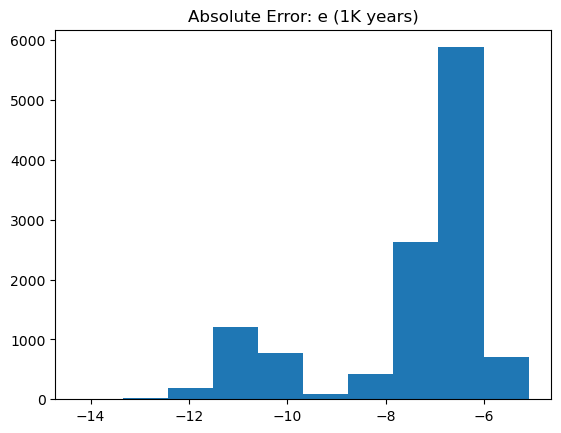

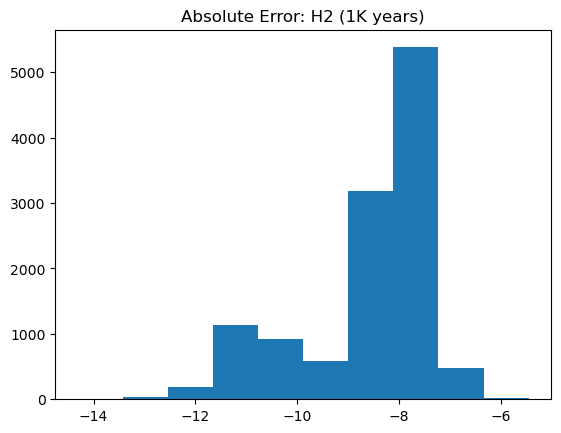

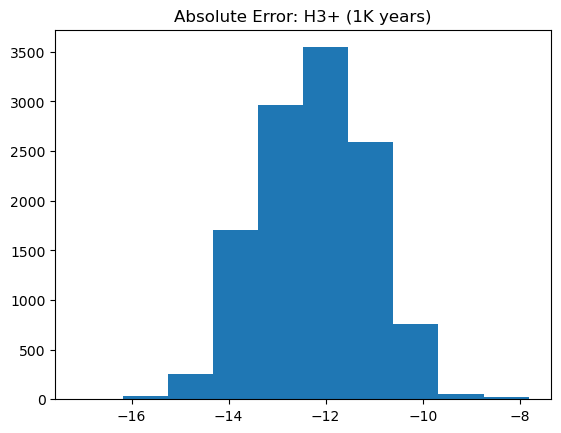

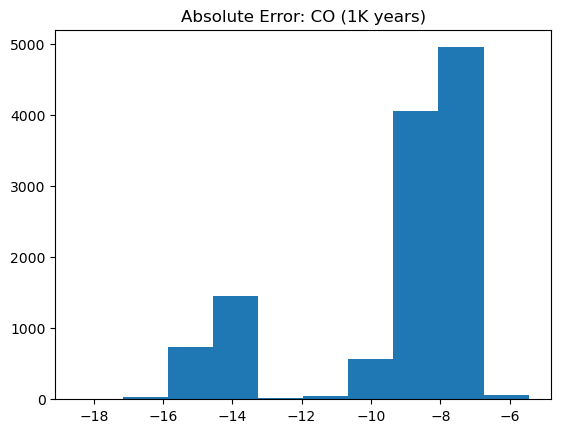

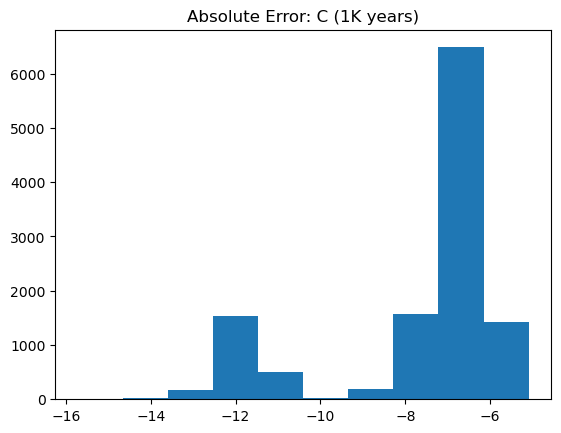

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Absolute Error: e (1K years)')
plt.hist(np.log10(datamat[:,16]))
plt.figure()
plt.title('Absolute Error: H2 (1K years)')
plt.hist(np.log10(datamat[:,17]))
plt.figure()
plt.title('Absolute Error: H3+ (1K years)')
plt.hist(np.log10(datamat[:,18]))
plt.figure()
plt.title('Absolute Error: CO (1K years)')
plt.hist(np.log10(datamat[:,19]))
plt.figure()
plt.title('Absolute Error: C (1K years)')
plt.hist(np.log10(datamat[:,20]))

(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
        0.045, 0.046, 0.047, 0.048, 0.049, 0.05 ]),
 array([-16.  , -15.76, -15.52, -15.28, -15.04, -14.8 , -14.56, -14.32,
        -14.08, -13.84, -13.6 , -13.36, -13.12, -12.88, -12.64, -12.4 ,
        -12.16, -11.92, -11.68, -11.44, -11.2 , -10.96, -10.72, -10.48,
        -10.24, -10.  ,  -9.76,  -9.52,  -9.28,  -9.04,  -8.8 ,  -8.56,
         -8.32,  -8.08,  -7.84,  -7.6 ,  -7.36,  -7.12, 

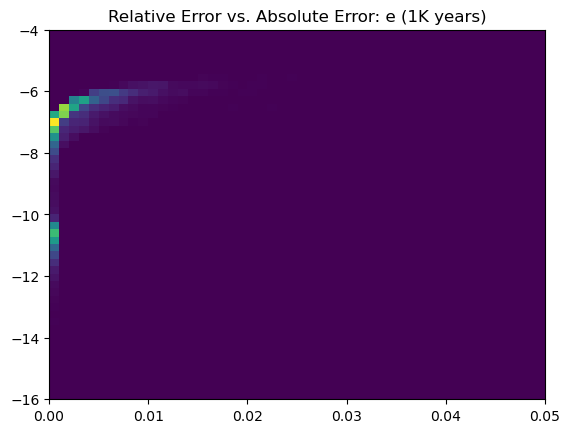

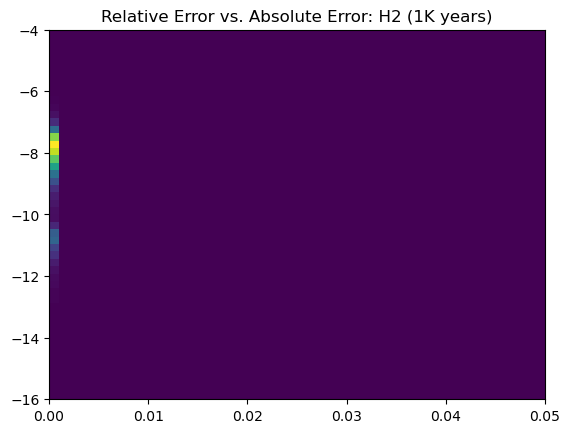

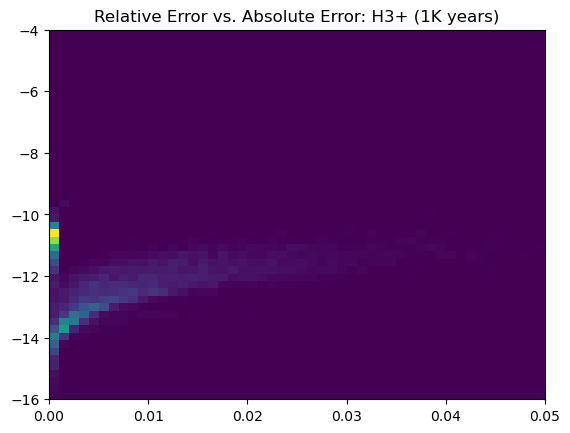

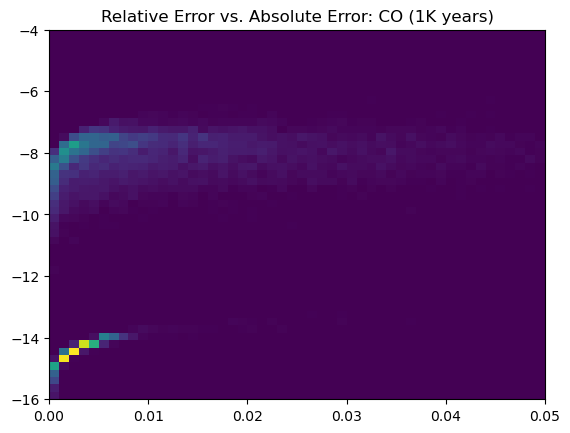

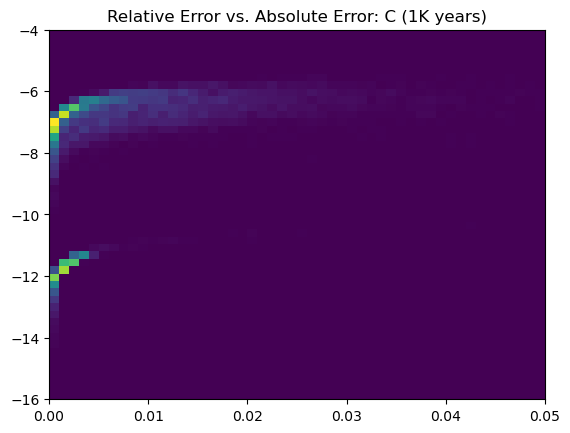

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Relative Error vs. Absolute Error: e (1K years)')
plt.hist2d(datamat[:,11], np.log10(datamat[:,16]), range=[[0,0.05],[-16,-4]], bins=[50,50])
plt.figure()
plt.title('Relative Error vs. Absolute Error: H2 (1K years)')
plt.hist2d(datamat[:,12], np.log10(datamat[:,17]), range=[[0,0.05],[-16,-4]], bins=[50,50])
plt.figure()
plt.title('Relative Error vs. Absolute Error: H3+ (1K years)')
plt.hist2d(datamat[:,13], np.log10(datamat[:,18]), range=[[0,0.05],[-16,-4]], bins=[50,50])
plt.figure()
plt.title('Relative Error vs. Absolute Error: CO (1K years)')
plt.hist2d(datamat[:,14], np.log10(datamat[:,19]), range=[[0,0.05],[-16,-4]], bins=[50,50])
plt.figure()
plt.title('Relative Error vs. Absolute Error: C (1K years)')
plt.hist2d(datamat[:,15], np.log10(datamat[:,20]), range=[[0,0.05],[-16,-4]], bins=[50,50])